# **Exercise 2: Part of Speech Tagging and Neural Language Modeling [SOLUTIONS]**

In this exercise, we will cover parts from lectures 4 (Neural Language Modeling) and 5 (Part of Speech Tagging).
The exercise mostly consists of python implementations of POS tagging with HMM and Viterbi decoding, where you have to fill in the blank start in parts that start with `# FILL IN:`
Additionally, you will be directed to follow a tutorial on implementing transformers.

Relevant SLP chapters:
* POS Tagging: Chapter 17
* Neural Language Modeling: Chapter 9, 10, 11

## **Ex.1: POS tagging using a Hidden Markov Model**

Let's start by downloading a dataset and see what the data looks like.

We make use of a sample from the *CONLL-2003++* dataset, from here: [https://github.com/ZihanWangKi/CrossWeigh](https://github.com/ZihanWangKi/CrossWeigh).

In [ ]:
!pip install -q pandas scikit-learn matplotlib

In [ ]:
import sys
import time
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score

np.set_printoptions(linewidth=np.inf, precision=2)  # To not have matrices wrap around when printing

We have created a repository where the data can be accessed. Let's clone it and change directory to the one containing the data files.

In [ ]:
!git clone https://github.com/LAGoM-NLP/NLP-data-repo.git

Cloning into 'NLP-data-repo'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 10 (delta 0), reused 10 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (10/10), 1005.71 KiB | 7.86 MiB/s, done.


In [ ]:
%cd /content/NLP-data-repo/exercise2/

/content/NLP-data-repo/exercise2


In [ ]:
# Check out what the file looks like
with open("data/conllpp_dev.txt", "r") as f:
    for idx, line in enumerate(f):
        if idx > 20:
            break
        print("\t".join(line.strip().split()))

-DOCSTART-	-X-	-X-	O

CRICKET	NNP	B-NP	O
-	:	O	O
LEICESTERSHIRE	NNP	B-NP	B-ORG
TAKE	NNP	I-NP	O
OVER	IN	B-PP	O
AT	NNP	B-NP	O
TOP	NNP	I-NP	O
AFTER	NNP	I-NP	O
INNINGS	NNP	I-NP	O
VICTORY	NN	I-NP	O
.	.	O	O

LONDON	NNP	B-NP	B-LOC
1996-08-30	CD	I-NP	O

West	NNP	B-NP	B-MISC
Indian	NNP	I-NP	I-MISC
all-rounder	NN	I-NP	O
Phil	NNP	I-NP	B-PER


### File format

Each file contains sentences, where each line is a word and some annotations. The sentences are seperated by a white line. The first item on each line is a word, the second a part-of-speech (POS) tag, the third a syntactic chunk tag and the fourth the named entity tag.

Let's start by processing the data so it is a more useful format. We will put everything into lists, so that each item of the list is either the words of the sentence, or the labels of the sentence.

In [ ]:
def process_split(path_to_raw_txt):
    # these lists will contain the full splits data
    words, pos, chunks, ners = [], [], [], []
    with open(path_to_raw_txt, "r") as f:
        # we need buffers for collecting the current sentence
        buffer_words, buffer_pos, buffer_chunks, buffer_ners = [], [], [], []
        # we will loop over all the lines in the file
        for line in f:
            line = line.strip()
            # The file starts with a -DOCSTART- indicater. skip this line
            if line.startswith("-DOCSTART-"):
                continue
            # if we reach a blank line, we add the complete buffer to the full splits lists
            if len(line) == 0:
                # make sure we don't add empty buffer to the data lists
                if len(buffer_words) != 0:
                    words.append(buffer_words)
                    pos.append(buffer_pos)
                    chunks.append(buffer_chunks)
                    ners.append(buffer_ners)
                # now we need to reset the buffers for the next sentence
                buffer_words, buffer_pos, buffer_chunks, buffer_ners = [], [], [], []
            else:
                # split the current line into the 4 elements and add them to the current sentence
                elements = line.split()
                buffer_words.append(elements[0].lower())  # lowercase so we don't have so many unique words
                buffer_pos.append(elements[1])
                buffer_chunks.append(elements[2])
                buffer_ners.append(elements[3])
        # if we finished the loop and we still have a sentence in our buffer, we add it to the full list
        if len(buffer_words) != 0:
            words.append(buffer_words)
            pos.append(buffer_pos)
            chunks.append(buffer_chunks)
            ners.append(buffer_ners)
    return words, pos, chunks, ners


train_words, train_pos, train_chunks, train_ners = process_split("data/conllpp_train.txt")
dev_words, dev_pos, dev_chunks, dev_ners = process_split("data/conllpp_dev.txt")
test_words, test_pos, test_chunks, test_ners = process_split("data/conllpp_test.txt")

print("WORDS: ", train_words[:3])
print("POS TAGS: ", train_pos[:3])
print("CHUNKS: ", train_chunks[:3])
print("NER TAGS: ", train_ners[:3])

WORDS:  [['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.'], ['peter', 'blackburn'], ['brussels', '1996-08-22']]
POS TAGS:  [['NNP', 'VBZ', 'JJ', 'NN', 'TO', 'VB', 'JJ', 'NN', '.'], ['NNP', 'NNP'], ['NNP', 'CD']]
CHUNKS:  [['B-NP', 'B-VP', 'B-NP', 'I-NP', 'B-VP', 'I-VP', 'B-NP', 'I-NP', 'O'], ['B-NP', 'I-NP'], ['B-NP', 'I-NP']]
NER TAGS:  [['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O'], ['B-PER', 'I-PER'], ['B-LOC', 'O']]


The data is usable now and looks good. Now we start implementing a POS model.

For our HMM, we will need to prepare several probabilities for our Markov chain.
We will collect a set of possible labels and possible tokens from the train data.

We add a start-of-sentence (`<SOS>`) token at the beginning of every sentence

In [ ]:
count_labels = Counter()
count_words = Counter()
count_transitions = Counter()

# count the words
for sent in train_words:
    count_words["<SOS>"] += 1
    for word in sent:
        # remember, we lowercase all the words, to reduce unique number of tokens
        count_words[word] += 1

# count the labels
for labels in train_pos:
    count_labels["<SOS>"] += 1
    for label in labels:
        count_labels[label] += 1

    # FILL IN: the loop for counting labels

# count the possible transitions for the labels
for labels in train_pos:
    prev_label = "<SOS>"
    for label in labels:
        count_transitions[(prev_label, label)] += 1
        prev_label = label

    # FILL IN: the loop for counting the transitions between labels
    # the first transition is from the <SOS> token to the first word in the sentence
    # tip: store a variable with the conditional label of the transition


print("=" * 10)
print("Unique words: {}".format(len(count_words)))
print(f"Number of labels: {len(count_labels)}, labels: {count_labels.most_common(10)}")
print(f"Number of transitions: {len(count_transitions)}, bigrams: {count_transitions.most_common(10)}")

Unique words: 21010
Number of labels: 46, labels: [('NNP', 34392), ('NN', 23899), ('CD', 19704), ('IN', 19064), ('<SOS>', 14041), ('DT', 13453), ('JJ', 11831), ('NNS', 9903), ('VBD', 8293), ('.', 7389)]
Number of transitions: 1143, bigrams: [(('NNP', 'NNP'), 11130), (('CD', 'CD'), 7259), (('NN', 'IN'), 6426), (('IN', 'DT'), 5999), (('DT', 'NN'), 5855), (('JJ', 'NN'), 5428), (('<SOS>', 'NNP'), 5421), (('IN', 'NNP'), 4518), (('NNP', 'CD'), 4002), (('DT', 'JJ'), 3634)]


We counted almost everything, we didn't count the conditional pairs of words and labels yet.

To avoid zero probabilities, we create an unknown ('\<UNK\>') token. We will only use the most common words as features, the counts of the remaining words are moved towards the unknown token. Given we have 21,000 unique words, we use the 20,000 most common words.

We need to take this into account when counting the word-label pairs

In [ ]:
count_observation = Counter()

# count the conditional pairs between the words and labels
vocab_words = dict(count_words.most_common(20000))
for sent, labels in zip(train_words, train_pos):
    # add a SOS pair at the beginning of every sentence
    count_observation[("<SOS>", "<SOS>")] += 1
    for word, label in zip(sent, labels):
        if word in vocab_words.keys():
            count_observation[(word, label)] += 1
        else:
            count_observation[("<UNK>", label)] += 1

    # FILL IN: count all the observation tuples
    # don't forget to check if the word is in the vocabulary, otherwise count as <UNK>

examples = [
    f"{word=} {tag=}: {count}"
    for (word, tag), count in sorted(count_observation.items(), key=lambda item: item[1], reverse=True)[:10]
]
examples_str = "\n".join(examples)
print(f"Number of unique word-label pairs: {len(count_observation)} example pairs:\n{examples_str}")

Number of unique word-label pairs: 24323 example pairs:
word='<SOS>' tag='<SOS>': 14041
word='the' tag='DT': 8383
word='.' tag='.': 7374
word=',' tag=',': 7290
word='of' tag='IN': 3815
word='in' tag='IN': 3601
word='to' tag='TO': 3424
word='a' tag='DT': 3184
word='and' tag='CC': 2872
word='(' tag='(': 2861


Now we counted everything, we can create the probabilities matrices and vectors.
We must make sure that we always keep the same order for all our words and labels.
So we will create a word and label vocab.

In [ ]:
# Creating the vocabs and mappings between tokens and ids
word2id_vocab = {k: i for i, (k, c) in enumerate(count_words.most_common(20000))}
word2id_vocab["<UNK>"] = 20000
label2id_vocab = {k: i for i, (k, c) in enumerate(count_labels.most_common())}
id2label_vocab = {i: k for k, i in label2id_vocab.items()}
id2word_vocab = {v: k for k, v in word2id_vocab.items()}

Next let us compute the probabilities for the transitions.
Since we might have missed a transition, we make use of Laplace smoothing for the transition probabilities.  

In [ ]:
# Now the transitions
# We need to count the total times each label is used as a conditional (the first element in the bigram)
conditional_totals = Counter()

# FILL IN: create a loop that fills conditional_totals
for bigram, count in count_transitions.items():
    conditional_totals[bigram[0]] += count

# we need the smoothing constant for Laplace smoothing
smoothing_constant = len(label2id_vocab)

# now we create the probability matrix
prob_transition_matrix = np.zeros([len(label2id_vocab), len(label2id_vocab)])
for label_i, id_i in label2id_vocab.items():
    ## FILL IN: the denominator
    denominator = conditional_totals[label_i] + smoothing_constant
    for label_j, id_j in label2id_vocab.items():
        if (label_i, label_j) in count_transitions:
            numerator = count_transitions[(label_i, label_j)] + 1
        else:
            numerator = 1
        # FILL IN: the numerator.
        # tip: remember that not every transition exists
        prob_transition_matrix[id_i, id_j] = numerator / denominator

# this output should be a vector of all 1s
print(np.sum(prob_transition_matrix, 1))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
# Lets have a quick look at a part of the transition matrix
tags_df = pd.DataFrame(prob_transition_matrix, columns=label2id_vocab.keys(), index=label2id_vocab.keys())
tags_df.iloc[:10, :10]

,NNP,NN,CD,IN,<SOS>,DT,JJ,NNS,VBD,.
NNP,0.330218,0.047199,0.118755,0.052183,0.000030,0.003323,0.011570,0.017058,0.057850,0.050314
NN,0.040002,0.121779,0.028217,0.271479,0.000042,0.007434,0.011743,0.052167,0.064459,0.094703
CD,0.088875,0.065162,0.461538,0.038462,0.000064,0.002352,0.027718,0.109282,0.003814,0.033630
IN,0.237118,0.093871,0.072673,0.017158,0.000052,0.314828,0.077238,0.040298,0.000682,0.000840
<SOS>,0.384894,0.078015,0.076099,0.038049,0.000071,0.092355,0.055086,0.058210,0.003549,0.000426
DT,0.122002,0.434841,0.030445,0.007129,0.000074,0.001485,0.269919,0.062375,0.003861,0.001411
JJ,0.065408,0.461767,0.028664,0.050608,0.000085,0.004933,0.091265,0.159990,0.005699,0.016926
NNS,0.013941,0.021479,0.018381,0.279740,0.000103,0.006506,0.013527,0.008777,0.103779,0.111524
VBD,0.066803,0.031599,0.046137,0.145741,0.000120,0.162441,0.047699,0.024150,0.002163,0.080380
.,0.002188,0.002188,0.002188,0.002188,0.002188,0.002188,0.002188,0.002188,0.002188,0.002188


And finally we compute the state observation probabilities, for a word given a label.
Even though we already have unknown labels for the words, we will still use Laplace smoothing here.

In [ ]:
conditional_totals = Counter()
# We need to count the total times each label is used as a conditional (the first element in the bigram)
# FILL IN: conditional_totals
for (word, label), count in count_observation.items():
    conditional_totals[label] += count

# we define a smoothing constant for the Laplace smoothing. This is equal to the number of possible observations
smoothing_constant = len(word2id_vocab)

# now we create the probability matrix
prob_observation_matrix = np.zeros([len(label2id_vocab), len(word2id_vocab)])
for label, label_id in label2id_vocab.items():
    # FILL IN: the denominator
    denominator = conditional_totals[label] + smoothing_constant
    for word, word_id in word2id_vocab.items():
        if (word, label) in count_observation:
            numerator = count_observation[(word, label)] + 1
        else:
            numerator = 1
        # FILL IN: the numerator.
        # tip: remember that not every transition exists
        prob_observation_matrix[label_id, word_id] = numerator / denominator

# Some trickery to show examples
zipped = zip(id2label_vocab.values(), np.argmax(prob_observation_matrix, 1), np.max(prob_observation_matrix, 1))
examples = [next(zipped) for _ in range(20)]
formatted_examples = "\n".join(
    f"LABEL: {label}, WORD: {id2word_vocab[max_id]}, LIKELIHOOD: {prob:.2f}" for label, max_id, prob in examples
)

print(np.sum(prob_observation_matrix, 1))
print("Most likely word per label")
print(formatted_examples)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Most likely word per label
LABEL: NNP, WORD: u.s., LIKELIHOOD: 0.01
LABEL: NN, WORD: year, LIKELIHOOD: 0.01
LABEL: CD, WORD: 1, LIKELIHOOD: 0.04
LABEL: IN, WORD: of, LIKELIHOOD: 0.10
LABEL: <SOS>, WORD: <SOS>, LIKELIHOOD: 0.41
LABEL: DT, WORD: the, LIKELIHOOD: 0.25
LABEL: JJ, WORD: first, LIKELIHOOD: 0.01
LABEL: NNS, WORD: results, LIKELIHOOD: 0.01
LABEL: VBD, WORD: said, LIKELIHOOD: 0.06
LABEL: ., WORD: ., LIKELIHOOD: 0.27
LABEL: ,, WORD: ,, LIKELIHOOD: 0.27
LABEL: VB, WORD: be, LIKELIHOOD: 0.02
LABEL: VBN, WORD: been, LIKELIHOOD: 0.02
LABEL: RB, WORD: not, LIKELIHOOD: 0.02
LABEL: CC, WORD: and, LIKELIHOOD: 0.12
LABEL: TO, WORD: to, LIKELIHOOD: 0.15
LABEL: PRP, WORD: he, LIKELIHOOD: 0.03
LABEL: (, WORD: (, LIKELIHOOD: 0.13
LABEL: ), WORD: ), LIKELIHOOD: 0.13
LABEL: VBG, WORD: being, LIKELIHOOD: 0.00


$P(W_t=v_i|L_t=l_j)$ =``prob_observation_matrix[i][j]``

$P(L_t=l_i|L_{t-1}=l_j)$ =``prob_transition_matrix[i][j]``

where $W_x$, $L_x$ are random variables corresponding to a word resp. word label in our dataset at location $x$ and
$v_i$ is the $i$ th word in the word vocabulary, and $l_j$ the $j$ th label in the label vocabulary.

Now we have the needed matrices correctly created (they all sum to a probability of 1), we can use this to predict a sequence of labels for new sentences in our dev-set.

In [ ]:
def greedy_sentence_annotation(sentence):
    # we initialize our sequence with the SOS token
    sos_lab_id = label2id_vocab["<SOS>"]
    sos_word_id = word2id_vocab["<SOS>"]
    sentence_probability = prob_observation_matrix[sos_lab_id, sos_word_id]
    prev_id = sos_lab_id
    prediction_labels = []
    for word in sentence:
        if word in word2id_vocab:
            word_id = word2id_vocab[word]
        else:
            word_id = word2id_vocab["<UNK>"]
        probs_possible_label = sentence_probability.copy()
        probs_possible_label *= prob_observation_matrix[:, word_id]
        probs_possible_label *= prob_transition_matrix[prev_id, :]

        # FILL IN: update the probs_possible_label, so that it becomes a vector with a probability for each token.

        # This is where we are 'greedy': we just continue working with the best option at each timestep
        prev_id = np.argmax(probs_possible_label)
        prediction_labels.append(id2label_vocab[prev_id])
        sentence_probability = np.max(probs_possible_label)
    return sentence_probability, prediction_labels


def test_one_sentence(index):
    prob, pred_labels = greedy_sentence_annotation(dev_words[index])
    col_widths_formatting = "{:<20s} {:<15s} {:<15s}"
    print(col_widths_formatting.format("Word", "True POS tag", "Pred. POS tag"))
    for w, t, p in zip(dev_words[index], dev_pos[index], pred_labels):
        print(col_widths_formatting.format(w, t, p))
    print("pred probabilty", prob)

In [ ]:
test_one_sentence(830)

Word                 True POS tag    Pred. POS tag  
"                    "               "              
lebed                NN              NNP            
is                   VBZ             VBZ            
now                  RB              RB             
in                   IN              IN             
chechnya             NNP             NNP            
solving              VBG             NNP            
some                 DT              DT             
problems             NNS             NNS            
,                    ,               ,              
"                    "               "              
interfax             NN              NNP            
quoted               VBN             VBD            
chernomyrdin         NNP             NNP            
as                   IN              IN             
saying               VBG             VBG            
.                    .               .              
"                    "               "        

### The Viterbi Algorithm

For this algorithm we follow the pseudocode given in the book Speech and Language Processing (3rd ed. draft), by Dan Jurafsky and James H. Martin. This can be found in chapter 17.4, figure 17.10.

In [ ]:
def viterbi(sentence):
    T = len(sentence) + 1
    N = len(label2id_vocab)
    # Create matrices for storing progress moving through the Viterbi chain
    viterbi_matrix = np.zeros((N, T))
    backpointer_matrix = np.zeros((N, T))
    sos_lab_id = label2id_vocab["<SOS>"]
    sos_word_id = word2id_vocab["<SOS>"]
    start_prob = prob_observation_matrix[sos_lab_id, sos_word_id]
    # Probability of every label at the start is 0, except for the <SOS> tag.
    for s in range(N):
        viterbi_matrix[s, 0] = 0
        backpointer_matrix[s, 0] = sos_lab_id
    viterbi_matrix[sos_lab_id, 0] = start_prob

    # Start looping over the sentence and start filling the matrices
    for t_step in range(1, T):
        if sentence[t_step - 1] in word2id_vocab:
            word_id = word2id_vocab[sentence[t_step - 1]]
        else:
            word_id = word2id_vocab["<UNK>"]
        for s in range(N):
            # probability of sequence till now
            state_prob = viterbi_matrix[:, t_step - 1].copy()
            # probability for transition from every previous label to label s
            state_prob *= prob_transition_matrix[:, s]
            # probability observation
            state_prob *= prob_observation_matrix[s, word_id]
            viterbi_matrix[s, t_step] = np.max(state_prob)
            backpointer_matrix[s, t_step] = np.argmax(state_prob)
        # FILL IN: this for loop, so that in every timestep 1 column of both
        # viterbi_matrix and backpointer_matrix is filled.
        # with a probability for each token.

    # now we simply select the best path in the final column
    best_path_prob = np.max(viterbi_matrix[:, -1])
    best_path_pointer = int(np.argmax(viterbi_matrix[:, -1]))

    # given the path, we track back through the backpointers to create the entire label sequence
    best_path = [best_path_pointer]
    for t_step in range(T - 1, 1, -1):
        best_path.append(int(backpointer_matrix[best_path[-1], t_step]))
    best_path = [id2label_vocab[i] for i in best_path[::-1]]
    return best_path_prob, best_path


def test_one_sentence_viterbi(index):
    prob, pred_labels = viterbi(dev_words[index])
    col_widths_formatting = "{:<20s} {:<15s} {:<15s}"
    print(col_widths_formatting.format("Word", "True POS tag", "Pred. POS tag"))
    for w, t, p in zip(dev_words[index], dev_pos[index], pred_labels):
        print(col_widths_formatting.format(w, t, p))
    print("pred probabilty", prob)

In [ ]:
test_one_sentence_viterbi(830)

Word                 True POS tag    Pred. POS tag  
"                    "               "              
lebed                NN              NNP            
is                   VBZ             VBZ            
now                  RB              RB             
in                   IN              IN             
chechnya             NNP             NNP            
solving              VBG             VBD            
some                 DT              DT             
problems             NNS             NNS            
,                    ,               ,              
"                    "               "              
interfax             NN              PRP            
quoted               VBN             VBD            
chernomyrdin         NNP             VBN            
as                   IN              IN             
saying               VBG             VBG            
.                    .               .              
"                    "               "        

## Evaluation
For the evaluation we will make use of the F1 metric. We simply use a pre-implemented function from sklearn.

In [ ]:
all_true_labels = []
all_greedy_pred = []
all_viterbi_pred = []
greedy_times = []
viterbi_times = []

for sent, true_labels in zip(dev_words, dev_pos):
    start = time.time()
    _, greedy_pred = greedy_sentence_annotation(sent)
    stop = time.time()
    greedy_times.append(stop - start)
    start = time.time()
    _, vitebi_pred = viterbi(sent)
    stop = time.time()
    viterbi_times.append(stop - start)
    all_true_labels += true_labels
    all_greedy_pred += greedy_pred
    all_viterbi_pred += vitebi_pred

f1_greedy = f1_score(all_true_labels, all_greedy_pred, average="macro")
f1_viterbi = f1_score(all_true_labels, all_viterbi_pred, average="macro")

print("F1 Score greedy HMM:{}. total runtime: {}".format(round(f1_greedy, 4), round(sum(greedy_times), 4)))
print("F1 Score Viterbi HMM:{}. total runtime: {}".format(round(f1_viterbi, 4), round(sum(viterbi_times), 4)))

F1 Score greedy HMM:0.6256. total runtime: 1.3107
F1 Score Viterbi HMM:0.6687. total runtime: 45.5526


## **Ex.2: Attention Mechanism and Transformers**


##**Part 1: Attention**

The basis of a transformer architecture, first introduced in [Vaswani et al (2017)](https://dl.acm.org/doi/pdf/10.5555/3295222.3295349), is the attention mechanism. It allows the transformer to create contextual embeddings for words by attending to all inputs up to and including the word itself.

To illustrate the idea behind the attention mechanism, consider the following two sentences:

```python
s1 = "Denver lost from Minnesota because they were too strong"
s2 = "Denver lost from Minnesota because they were too weak"
```

Note that "they" in the first sentence refers to Minnesota, while it refers to Denver in the second sentence.
The words "strong" and "weak" informs us of this.
This toy exercise will illustrate how the attention mechanism can mimic this reasoning.
Assume that the words are encoded by the following vectors:

| Denver                              | lost                                | from                                | Minnesota                             | because                             | they                                | were                                | too                                 | strong                                |
| ----------------------------------- | ----------------------------------- | ----------------------------------- | ------------------------------------- | ----------------------------------- | ----------------------------------- | ----------------------------------- | ----------------------------------- | ------------------------------------- |
| $\begin{bmatrix}1\\0\end{bmatrix}$ | $\begin{bmatrix}0\\0\end{bmatrix}$ | $\begin{bmatrix}0\\0\end{bmatrix}$ | $\begin{bmatrix}-1\\0\end{bmatrix}$ | $\begin{bmatrix}0\\0\end{bmatrix}$ | $\begin{bmatrix}0\\1\end{bmatrix}$ | $\begin{bmatrix}0\\0\end{bmatrix}$ | $\begin{bmatrix}0\\0\end{bmatrix}$ | $\begin{bmatrix}-1\\1\end{bmatrix}$ |

Now, apply attention twice. Use the following matrices to transform the word encodings into
keys, queries and values:

$W_k = \begin{bmatrix}1 & 0\\0 & 1\\0&0\end{bmatrix}$
$W_q = \begin{bmatrix}1 & 0\\0 & 1\\0&0\end{bmatrix}$
$W_v = \begin{bmatrix}1 & 0\\0 & 1\end{bmatrix}$

Don't forget to apply softmax to the attention weights before applying them to the values.

Compare the words with high attention values for the query "they" in both sentences: does the difference make sense?

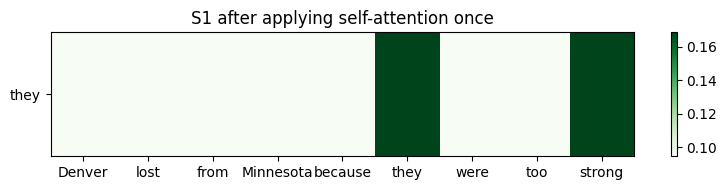

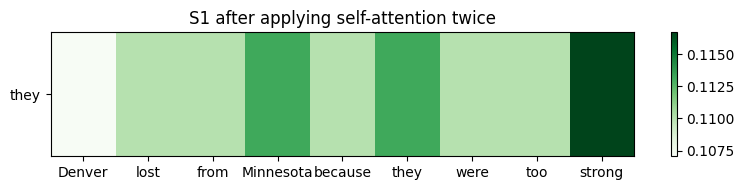

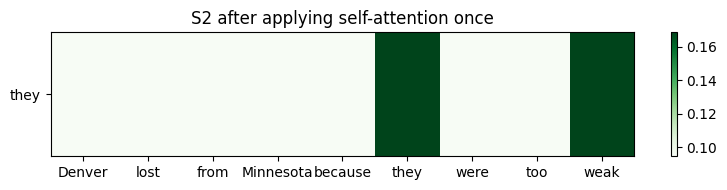

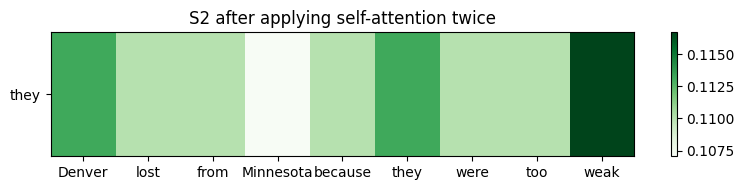

In [ ]:
np.random.seed(1)
plt.rcParams["figure.figsize"] = 8, 2

xaxis = np.array(range(0, 9))
first, last, step = xaxis[0], xaxis[-1], xaxis[1] - xaxis[0]
extent = [first - step / 2.0, last + step / 2.0, 0, 1]

s1 = "Denver lost from Minnesota because they were too strong".split()
s2 = "Denver lost from Minnesota because they were too weak".split()
encoding_1 = np.array(
    [
        [1, 0, 0, -1, 0, 0, 0, 0, -1],
        [0, 0, 0, 0, 0, 1, 0, 0, 1],
    ]
)  # 2x9
encoding_2 = np.array(
    [
        [1, 0, 0, -1, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 1],
    ]
)  # 2x9

Wk = np.array([[1, 0], [0, 1], [0, 0]])  # 3x2
Wq = np.array([[1, 0], [0, 1], [0, 0]])  # 3x2
Wv = np.array([[1, 0], [0, 1]])  # 2x2


def softmax(x, axis=0):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=axis)


def attend(encoding):
    # FILL IN: multiply the right matrices to calculate the attention weights and output (after softmax)
    # Tip: to multiply two matrices, you can use "@". E.g.,
    # a = np.array([[1,0],[2,0])
    # b = np.array([[1,0],[1,1])
    # c = a @ b

    k = Wk @ encoding  # 3x2 x 2x9 = 3x9
    q = Wq @ encoding  # 3x2 x 2x9 = 3x9
    v = Wv @ encoding  # 2x2 x 2x9 = 2x9
    scaler = np.sqrt(Wq.shape[0])
    attention_weights = softmax((k.transpose() @ q) / scaler)  # 9x3 x 3x9 = 9x9
    attention_output = v @ attention_weights  # 2x9 x 9x9 = 2x9
    return attention_weights, attention_output


def colormap(attention_weights, words, title):
    plt.imshow(attention_weights[np.newaxis, :], cmap="Greens", aspect="auto", extent=extent)
    plt.xticks(xaxis, words)
    plt.yticks([0.5], ["they"])
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.show()


# 5 is the index of the word "they", which want to plot when it's the query
they_idx = 5

for idx, (sentence, encoding) in enumerate(zip((s1, s2), (encoding_1, encoding_2))):
    attention_weights_1, attended_values_1 = attend(encoding)
    attention_weights_2, attended_values_2 = attend(attended_values_1)

    colormap(
        attention_weights_1[:, they_idx],
        sentence,
        f"S{idx + 1} after applying self-attention once",
    )
    colormap(
        attention_weights_2[:, they_idx],
        sentence,
        f"S{idx + 1} after applying self-attention twice",
    )

##**Part 2: Tranformers**

Understanding the attention mechanism is key to understanding how a transformer architecture works.

We now direct you to a tutorial, ['The Annotated Transformer'](https://nlp.seas.harvard.edu/annotated-transformer/), detailing the implementation of an encoder-decoder tranformer architecture, based on the paper 'Attention is All You Need' (Vaswani et al., 2017) linked above. A simplified explanation of each step in the tutorial is available in this blog post - ['The Illustrated Transformer'](https://jalammar.github.io/illustrated-transformer/) by Jay Alammar.

As part of this exercise session, you are required to follow Part 1 of the Annotated Transformer tutorial that will take you through the workings of a transformer in PyTorch. You may optionally also go through Part 2 and complete the tutorial, which while not required for the exercise, it will be very helpful for future exercises that involve transformers, and is generally good knowledge to have if you plan to continue working with transformers.